In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv
from statsmodels.tsa.stattools import pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
month = '201707'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

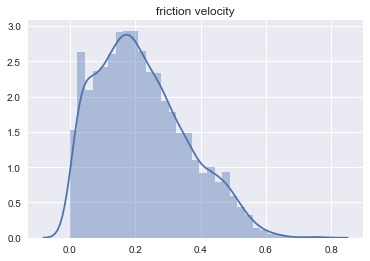

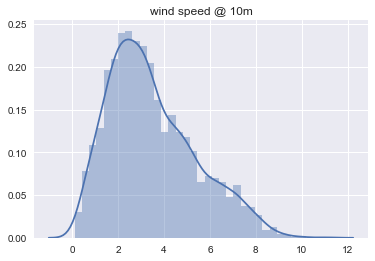

In [3]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

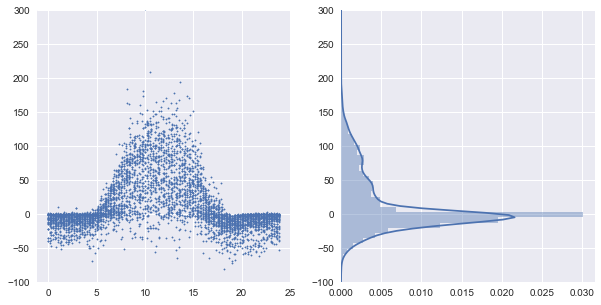

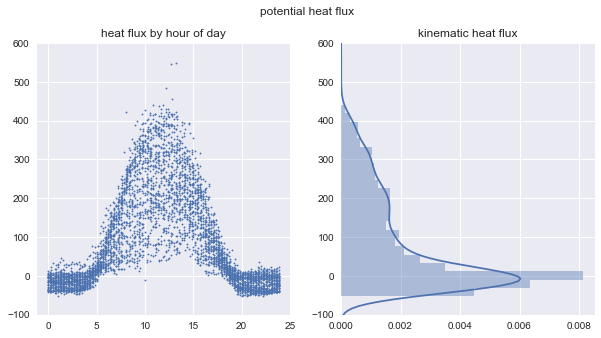

In [4]:
plt.figure(figsize=(10, 5))
plt.title('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 300)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
plt.ylim(-100, 300)
plt.show()

plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.title('heat flux by hour of day')
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.title('kinematic heat flux')
plt.ylim(-100, 600)
plt.show()

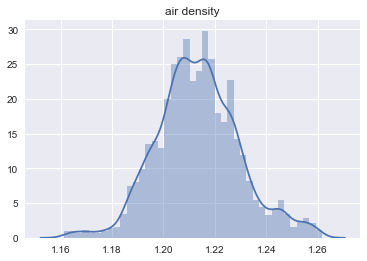

In [5]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

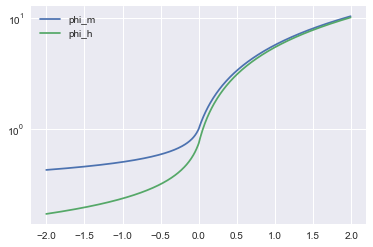

In [6]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

wind and temperature profile

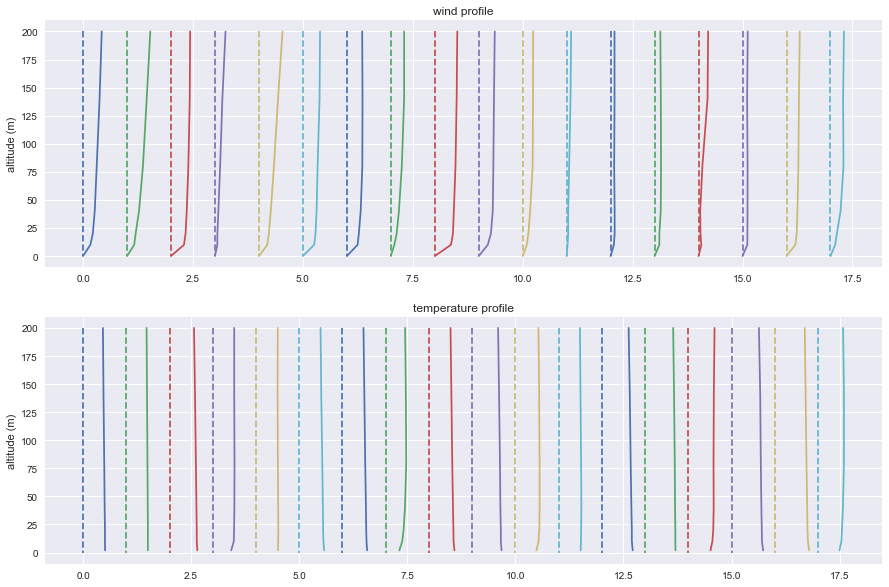

In [7]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient, obtained by weight averaging top and bottom derivatives (quantity is $x$ and altitude is $y$). Let $\Delta^+a_i=a_{i+1}-a_i$ and $\Delta^-a_i=a_i-a_{i-1}$, then

\begin{align*}
\frac{\partial x_i}{\partial y_i}
&=\frac{\Delta^+x_i}{\Delta^+y_i}\cdot\frac{\Delta^+y_i}{\Delta^+y_i+\Delta^-y_i}
+\frac{\Delta^-x_i}{\Delta^-y_i}\cdot\frac{\Delta^-y_i}{\Delta^+y_i+\Delta^-y_i} \\
&=\frac{\Delta^+x_i+\Delta^-x_i}{\Delta^+y_i+\Delta^-y_i} \\
&= \frac{x_{i+1}-x_{i-1}}{y_{i+1}-y_{i-1}}
\end{align*}

for boundary values we can only use the previous/next measurement

$$
\frac{\partial x_0}{\partial y_0}=\frac{x_1-x_0}{y_1-y_0}
$$

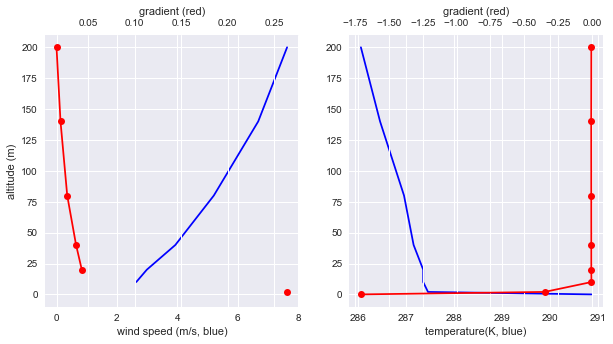

In [3]:
def get_derivative(xs, ys):
    dxdy = []
    for i in range(len(xs)):
        if i == 0:
            d = (ys[i] - ys[i + 1]) / (xs[i] - xs[i + 1])
        elif i == len(xs) - 1:
            d = (ys[i - 1] - ys[i]) / (xs[i - 1] - xs[i])
        else:
            d = (ys[i - 1] - ys[i + 1]) / (xs[i - 1] - xs[i + 1])

        dxdy.append(d)

    return dxdy


def get_wind_profile(tt, towmetds):
    ws = list(
        np.nan if towmetds['F'][tt].mask[i] else wind
        for i, wind in enumerate(towmetds['F'][tt].data)
    )

    zs = list(towmetds['z'][:])

    # no-slip condition
    ws.append(0)
    zs.append(0)

    dwdz = get_derivative(zs, ws)
    return zs, ws, dwdz


def get_temperature_profile(tt, towmetds, soilds):
    ts = list(towmetds['TA'][tt][:])
    zs = list(towmetds['z'][:])

    ts.append(soilds['TS00'][tt] + 273.15)
    zs.append(0)

    dtdz = get_derivative(zs, ts)
    return zs, ts, dtdz


tt = towmetds['time'][126]

wz, ws, dwdz = get_wind_profile(tt, towmetds)
tz, ts, dtdz = get_temperature_profile(tt, towmetds, soilds)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, wz, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, wz, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, tz, 'x-', c='b')
ax2.set_xlabel('temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, tz, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [4]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt']
computed_cols = ['phi_m', 'phi_h', 'zL', 'dwdz', 'dtdz', 'lval']
source_cols = ['IUST', 'ILE', 'IH', 'ITA_2', 'ITA_1', 'IF_2', 'ITA002', 'IP0']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
        soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    for i, tt in enumerate(towmetds['time']):
        wz, ws, dwdz = get_wind_profile(tt, towmetds)
        tz, ts, dtdz = get_temperature_profile(tt, towmetds, soilds)

        assert wz == tz
        for i, (z, wind, temp, dwind, dtemp) in enumerate(zip(wz, ws, ts, dwdz, dtdz)):
            if z > 50 or z < 2: # outside of the surface layer
                continue

            spec_hum = towmetds['Q'][tt][i]
            virtual_temp = temp * (1 + 0.61 * spec_hum)
            air_dens = 100 * meteods['P0'][tt] / (287.058 * virtual_temp)  # kg.m-3

            virtual_potential_temperature_flux = (
                fluxds['H'][tt] + 0.07 * fluxds['LE'][tt]
            ) / (1005 * air_dens)

            lval = -fluxds['UST'][tt]**3 * virtual_temp / (
                0.4 * 9.81 * virtual_potential_temperature_flux
            )  # m

            phi_m = dwind * 0.4 * z / fluxds['UST'][tt]
            phi_h = -(
                dtemp * 0.4 * z * fluxds['UST'][tt] * 1005 * air_dens
                / fluxds['H'][tt]
            )

            yield RowRecord(
                ds=month,
                year=month[:4],
                month=month[4:],
                daym=int(tt / 24),
                hday=tt % 24,
                tt=tt,

                air_dens=air_dens,
                H=fluxds['H'][tt],
                LE=fluxds['LE'][tt],
                ustar=fluxds['UST'][tt],
                temp=temp,
                virtual_temp=virtual_temp,
                soil_temp=273.15 + soilds['TS00'][tt],
                wind=towmetds['F'][tt, -2],

                z=z,
                lval=lval,
                zL=z / lval,
                dwdz=dwind,
                dtdz=dtemp,
                phi_m=phi_m,
                phi_h=phi_h,

                IUST=fluxds['IUST'][tt],
                ILE=fluxds['ILE'][tt],
                IH=fluxds['IH'][tt],
                ITA_2=towmetds['ITA'][tt][-2],
                ITA_1=towmetds['ITA'][tt][-1],
                IF_2=towmetds['IF'][tt][-2],
                ITA002=meteods['ITA002'][tt],
                IP0=meteods['IP0'][tt],

                co2flux=fluxds['FC'][tt],
                soilheat=fluxds['G0'][tt],
                netrad=fluxds['QN'][tt],
                spec_hum=spec_hum,
                dewpoint=towmetds['TD'][tt][-1],
                rel_hum=towmetds['RH'][tt][-1],
                press=meteods['P0'][tt],
                rain=meteods['RAIN'][tt],
            )

In [6]:
dframe_path = 'data/cabauw/processed.csv.gz'

if not os.path.exists(dframe_path):
    print('recomputing data (you take a coffee)')
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf
    
    sc = SparkContext(conf=SparkConf().setMaster('local[7]').set('spark.driver.memory', '14g'))
    all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

    try:
        df_rows = (sc.parallelize(all_months, len(all_months))
            #.sample(fraction=7 / len(all_months), withReplacement=False)
            .flatMap(process)
            .collect())
    finally:
        sc.stop()

    df = pd.DataFrame(df_rows)
    df.to_csv(dframe_path, index=False)


try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

print(len(df), 'recods')

3436416 recods


we can remove some data known to be of bad quality, i.e. $u_*<0.1$ and $\vert H\vert<10$

In [11]:
df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]

we also remove data from 201603 as it contains bad measurements for the fluxes

In [12]:
df[df.ds == 201603][['H', 'LE']].describe().T

count        mean          std          min        25%        50%  \
H   13368.0  316.126351  6203.482368 -1552.988037 -59.778019 -22.506733   
LE  13296.0   24.658386   426.851560 -6601.960000 -23.895900  29.174150   

           75%            max  
H    24.910757  144691.765625  
LE  113.093000    1549.670000

In [13]:
df = df[df.ds != 201603]

In [18]:
df[additional_cols].describe(include='all').T

count         mean         std         min          25%  \
dewpoint  2001744.0   280.570549    7.762623  190.449661   277.121368   
spec_hum  2001744.0     6.754601    2.500865   -0.656552     4.916068   
rel_hum   2001744.0    78.218365   16.291887    0.007615    68.749809   
press     2001744.0  1013.754406    9.938804  978.400024  1007.900024   
rain      2001744.0     0.016338    0.126664   -0.016667     0.000000   
co2flux   2001744.0    -0.057931    0.291628   -3.049525    -0.244524   
soilheat  2001744.0     2.554176   14.500265  -69.496613    -6.499646   
netrad    2001744.0    79.707697  167.182195 -109.265366   -36.315094   

                  50%          75%          max  
dewpoint   281.247314   285.382751   296.544373  
spec_hum     6.454567     8.490891    17.614822  
rel_hum     81.779957    90.611183   109.266533  
press     1014.400024  1020.500000  1040.500000  
rain         0.000000     0.000000     7.916667  
co2flux      0.037299     0.122024     5.244211  
soilheat    -0.910562     8.499336    84.367592  
netrad      -3.941498   165.324158   770.600830

In [14]:
df[measurement_cols].describe(include='all').T

count         mean         std         min          25%  \
air_dens      2001744.0     0.269895    0.109239    0.099593     0.197539   
H             2001744.0     2.059682   46.237620 -459.999756   -26.481699   
LE            2001744.0    74.748156  115.898342 -117.416000    -5.145440   
ustar         2001744.0     0.307320    0.143227    0.100004     0.198748   
wind          2001744.0     5.149140    2.347495    1.002586     3.420000   
temp          2001744.0   284.936568    6.495502  259.350006   280.350006   
virtual_temp  2001744.0  1467.219771  464.506917  173.999282  1123.213950   
soil_temp     1773456.0   284.473898    5.728240  272.583312   279.767470   
z             2001744.0    18.000000   14.212674    2.000000     8.000000   

                      50%          75%          max  
air_dens         0.250805     0.313874     2.005090  
H              -15.313450    26.161589   301.187653  
LE              22.786850   130.074000   595.863000  
ustar            0.282974     0.384980     1.313813  
wind             4.700000     6.390000    19.219999  
temp           284.949982   289.549988   306.549988  
virtual_temp  1406.698437  1786.854487  3524.099606  
soil_temp      284.527413   289.272835   301.509936  
z               15.000000    25.000000    40.000000

In [15]:
df[computed_cols].describe(include='all').T

count        mean          std           min        25%        50%  \
phi_m  1501308.0    1.803239     1.529542     -4.444776   1.005186   1.381068   
phi_h  1944672.0    0.086557     0.569595    -20.409393  -0.105138   0.109879   
zL     2001744.0   -0.058941     1.962299    -82.806393  -0.116222   0.035413   
dwdz   1501308.0    0.201261     0.260773     -0.096917   0.036404   0.062291   
dtdz   1944672.0    0.010540     0.125025     -1.058651  -0.013333  -0.003334   
lval   2001744.0  111.235312  1372.830423 -56474.352644 -19.361644  24.572344   

              75%            max  
phi_m    1.983021      15.496656  
phi_h    0.279489      22.172533  
zL       0.249813      27.904544  
dwdz     0.342000       1.922000  
dtdz     0.016666       1.160954  
lval   124.928759  326253.666461

In [16]:
df[index_cols].describe(include='all').T

count           mean         std       min            25%  \
ds     2001744.0  200927.478731  466.971542  200108.0  200510.000000   
year   2001744.0    2009.209925    4.671008    2001.0    2005.000000   
month  2001744.0       6.486236    3.403283       1.0       4.000000   
daym   2001744.0      14.710692    8.757027       0.0       7.000000   
hday   2001744.0      11.966065    6.944549       0.0       6.000000   
tt     2001744.0     365.022679  210.253423       0.0     187.833344   

                 50%            75%            max  
ds     200909.000000  201308.000000  201712.000000  
year     2009.000000    2013.000000    2017.000000  
month       6.000000       9.000000      12.000000  
daym       15.000000      22.000000      30.000000  
hday       12.000008      18.000004      23.833374  
tt        362.500031     542.833313     743.833374

In [17]:
df[source_cols].describe(include='all').T

count      mean       std  min  25%  50%  75%  max
IUST    2001744.0  2.258914  0.693727  2.0  2.0  2.0  2.0  7.0
ILE     2001744.0  2.431839  1.232810  2.0  2.0  2.0  2.0  7.0
IH      2001744.0  2.410690  1.199419  2.0  2.0  2.0  2.0  7.0
ITA_2   2001744.0  2.017733  0.272222  2.0  2.0  2.0  2.0  7.0
ITA_1   2001744.0  2.013668  0.229589  2.0  2.0  2.0  2.0  7.0
IF_2    2001744.0  2.014411  0.230898  2.0  2.0  2.0  2.0  7.0
ITA002  2001744.0  2.013668  0.229589  2.0  2.0  2.0  2.0  7.0
IP0     2001744.0  3.038127  0.383938  3.0  3.0  3.0  3.0  7.0

plot correlation matrix between data, computed values, and time of year (to check seasonality)

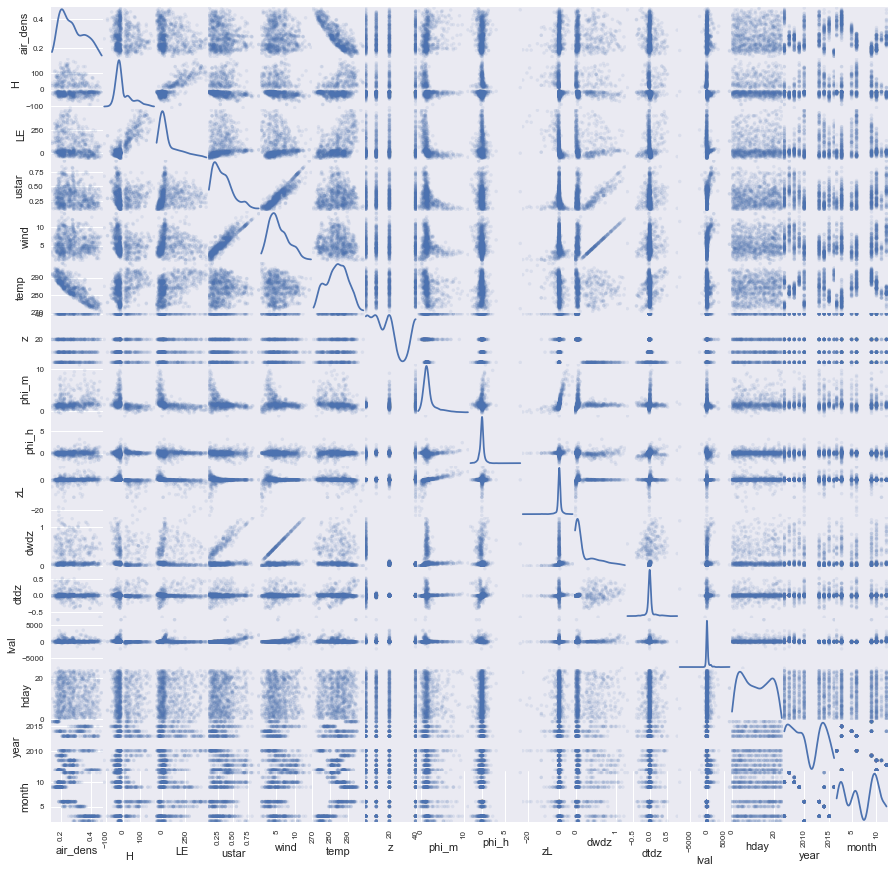

In [111]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']].drop('soil_temp', axis=1),
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

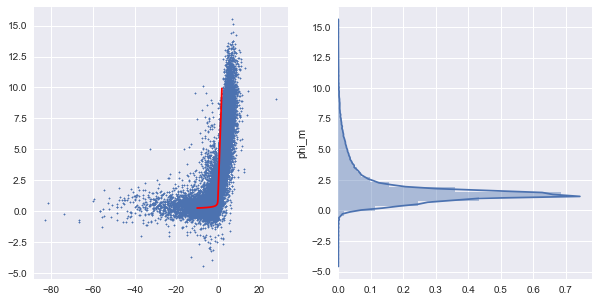

In [19]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
#plt.xlim(-10, 10)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_m.dropna(), vertical=True)
plt.show()

the data can be made to fit the line by doubling phi_m, or halving z/L

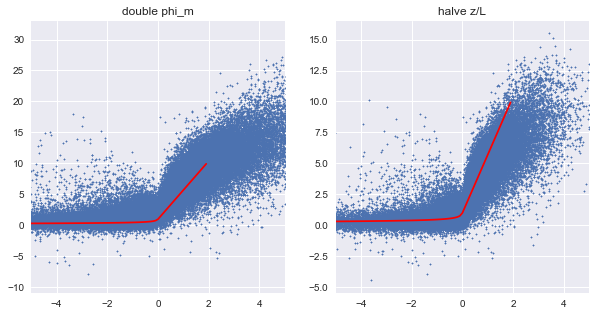

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('double phi_m')
plt.scatter(df.zL, df.phi_m * 2, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(-5, 5)
plt.subplot(1, 2, 2)
plt.title('halve z/L')
plt.scatter(df.zL / 2, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(-5, 5)
plt.show()

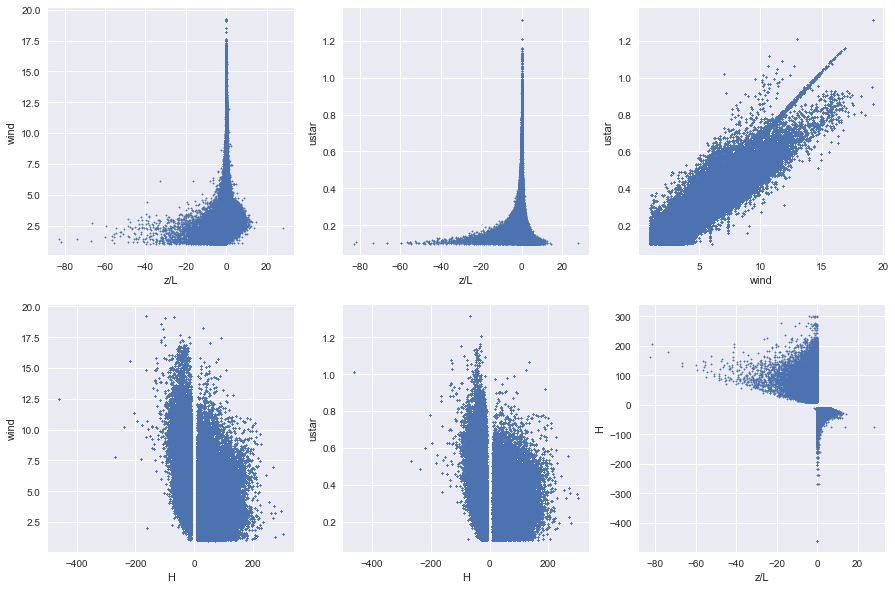

In [21]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('wind'); plt.xlabel('z/L')
plt.scatter(df.zL, df.wind, s=1)

plt.subplot(2, 3, 2)
plt.ylabel('ustar'); plt.xlabel('z/L')
plt.scatter(df.zL, df.ustar, s=1)

plt.subplot(2, 3, 3)
plt.scatter(df.wind, df.ustar, s=1)
plt.ylabel('ustar'); plt.xlabel('wind')

plt.subplot(2, 3, 4)
plt.scatter(df.H, df.wind, s=1)
plt.xlabel('H'); plt.ylabel('wind')

plt.subplot(2, 3, 5)
plt.scatter(df.H, df.ustar, s=1)
plt.xlabel('H'); plt.ylabel('ustar')

plt.subplot(2, 3, 6)
plt.scatter(df.zL, df.H, s=1)
plt.ylabel('H'); plt.xlabel('z/L')
plt.show()

in order to have phi_m close to 0 when z/L is negative, you would need no wind or large u*, none of which is true

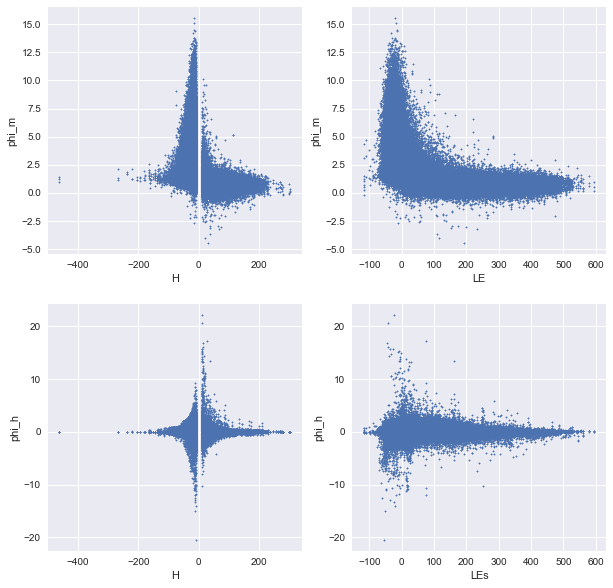

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.xlabel('H'); plt.ylabel('phi_m')
plt.scatter(df.H, df.phi_m, s=1)
plt.subplot(2, 2, 2); plt.xlabel('LE'); plt.ylabel('phi_m')
plt.scatter(df.LE, df.phi_m, s=1)
plt.subplot(2, 2, 3); plt.xlabel('H'); plt.ylabel('phi_h')
plt.scatter(df.H, df.phi_h, s=1)
plt.subplot(2, 2, 4); plt.xlabel('LEs'); plt.ylabel('phi_h')
plt.scatter(df.LE, df.phi_h, s=1)
plt.show()

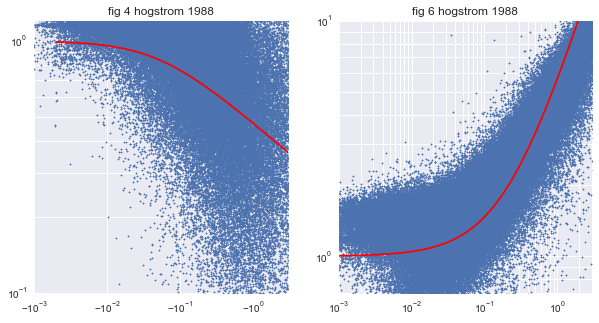

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL / 2, df.phi_m, s=1)
xx = np.arange(-3, -0.001, 0.001)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(-3, -0.001)
plt.xscale('symlog', linthreshx=0.001)
plt.ylim(0.1, 1.2)
plt.yscale('log')
plt.title('fig 4 hogstrom 1988')
plt.gca().invert_xaxis()
plt.grid(True, 'both')

plt.subplot(1, 2, 2)
plt.scatter(df.zL / 2, df.phi_m, s=1)
xx = np.arange(0.001, 3, 0.001)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
plt.xlim(0.001, 3)
plt.xscale('log')
plt.ylim(0.7, 10)
plt.yscale('log')
plt.title('fig 6 hogstrom 1988')
plt.grid(True, 'both')
plt.show()

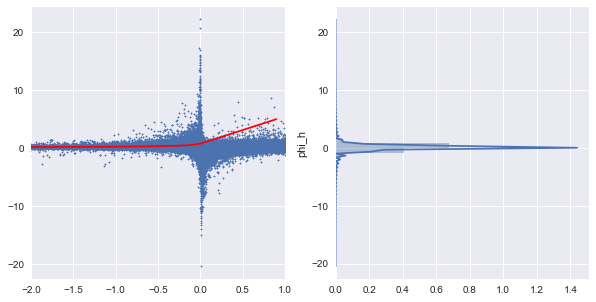

In [24]:
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL

    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
xx  = np.arange(-2, 1, 0.1)
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xlim(-2, 1)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_h.dropna(), vertical=True)
plt.show()

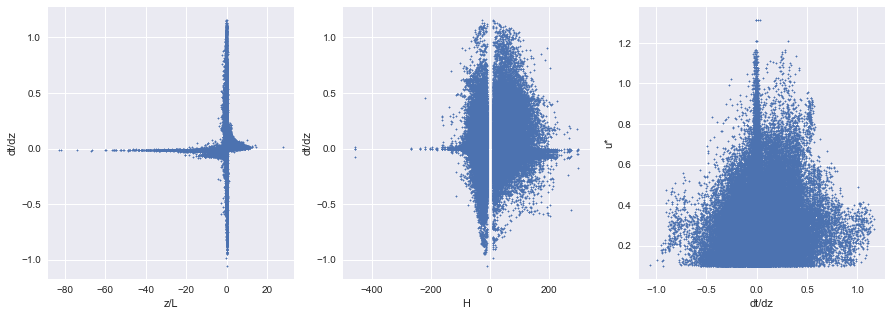

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df.zL, df.dtdz, s=1)
plt.xlabel('z/L'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 2)
plt.scatter(df.H, df.dtdz, s=1)
plt.xlabel('H'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 3)
plt.scatter(df.dtdz, df.ustar, s=1)
plt.xlabel('dt/dz'); plt.ylabel('u*')
plt.show()

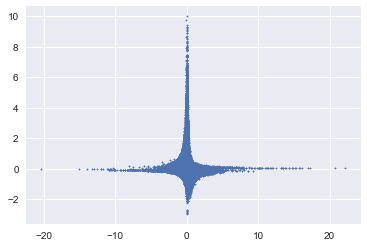

In [27]:
plt.scatter(df.phi_h, df.H / (1005 * df.air_dens * df.ustar), s=1)

very strong correlation with the previous sample, and 6 days seasonality very clear

## Checking $\phi_m$

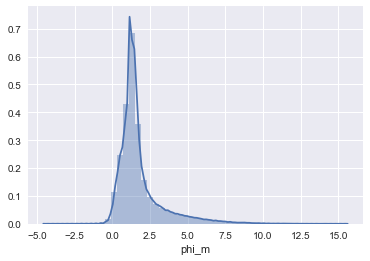

In [28]:
sns.distplot(df.phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for unstable conditions

In [29]:
ints = [-3, 0, 1, 2, 4, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[(df.phi_m >= low) & (df.phi_m < high)])
    print('[%d,%d)\t%d' % (low, high, count))

interv.	count
[-3,0)	18162
[0,1)	353580
[1,2)	759432
[2,4)	241182
[4,25)	128916


In [30]:
def plot_cdf(rvars, labels=None, ordinal=False):
    ''' plot the empirical cdf and a boxplot of multple random variables
        in the same chart, to ease comparison

        rvars contains a list of samples for each r.v.
        labels contains a label for each r.v.
    '''
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    if ordinal:
        all_levels = sorted(set(v for var in rvars for v in var))
        level_map = dict(zip(all_levels, range(len(all_levels))))
        inv_level_map = dict(zip(range(len(all_levels)), all_levels))
        rvars = [list(map(level_map.get, var)) for var in rvars]

    for i, values in enumerate(rvars):
        xx = sorted(values)
        yy = np.arange(len(values)) / len(values)
        lbl = labels[i] if labels is not None else None
        
        ax1.plot(xx, yy, label=lbl)

    if labels is not None:
        ax1.legend()

    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    if ordinal:
        ticklb = [
            # ticks are float, get label only on integral ticks
            (inv_level_map.get(int(t), '') if abs(int(t) - t) < 1e-9 else '')
            for t in ax1.get_xticks()
        ]

        ax1.set_xticklabels(ticklb)
        ax2.set_xticklabels(ticklb)

    return ax1, ax2


def inspect_col(colname, partition_by, interval, show=True, fig=None):
    old_pal = sns.color_palette()
    sns.set_palette('GnBu_d')

    vs = [
        df[colname][
            (df[partition_by] >= low) &
            (df[partition_by] < high)
        ].dropna()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    if fig is None:
        fig = plt.figure(figsize=(7, 5))

    ax1, ax2 = plot_cdf(
        vs, list(map(str, zip(interval[:-1], interval[1:]))),
        ordinal=colname in source_cols + ['ds']
    )
    ax1.set_title(colname)
    sns.set_palette(old_pal)
    
    if show:
        plt.show()
    
    return fig, ax1, ax2

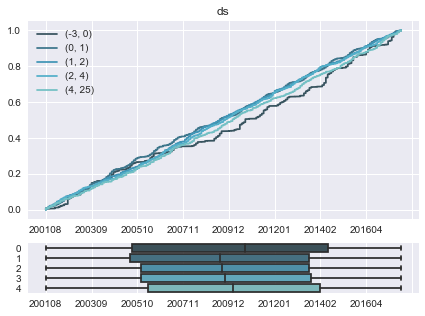

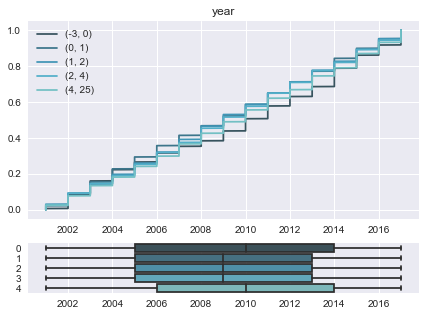

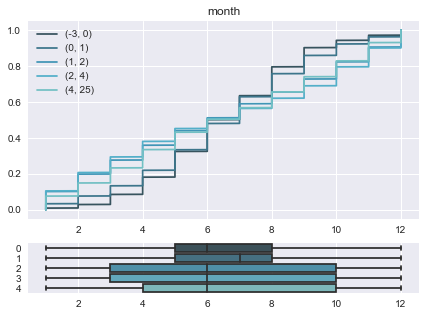

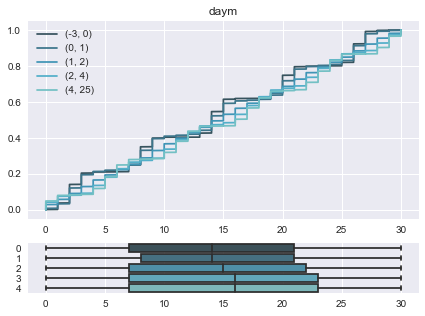

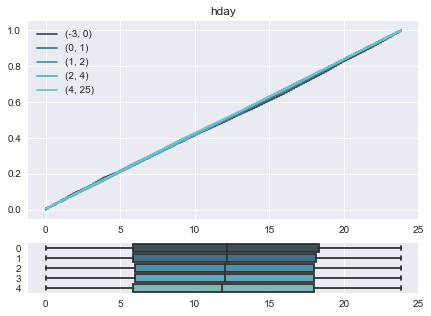

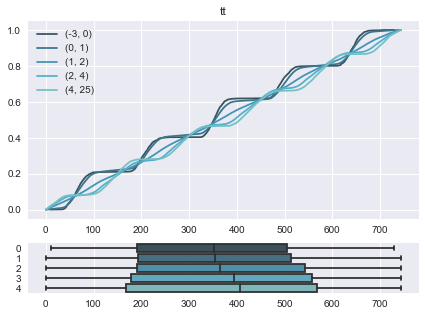

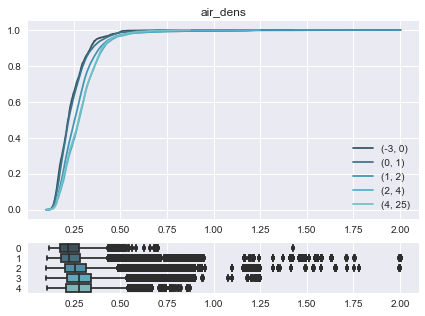

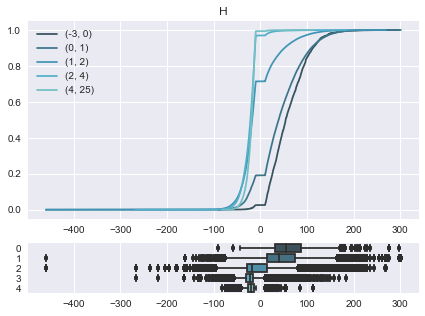

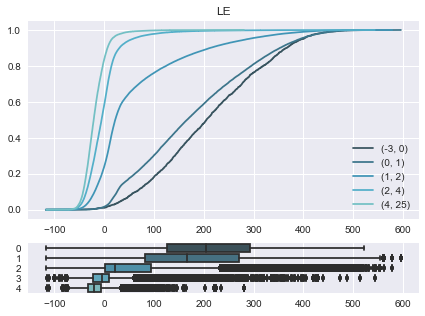

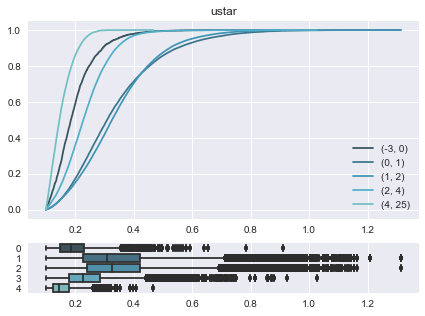

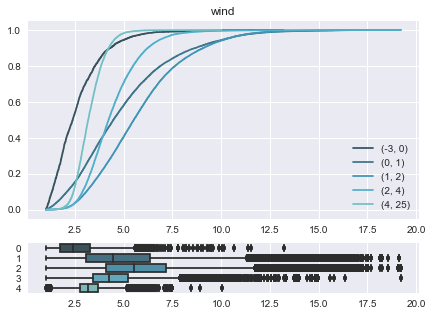

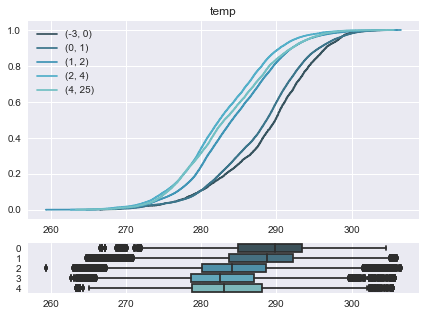

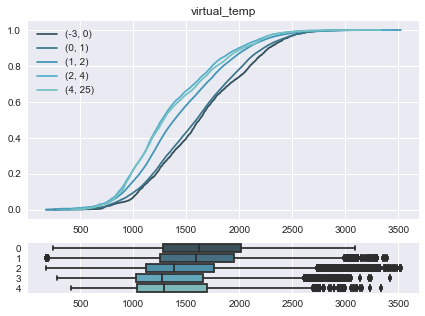

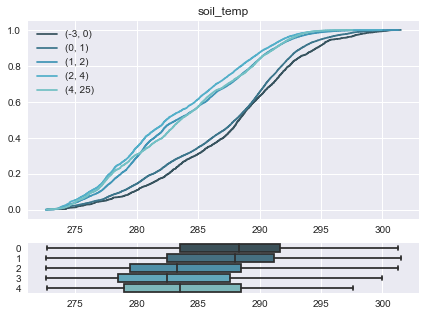

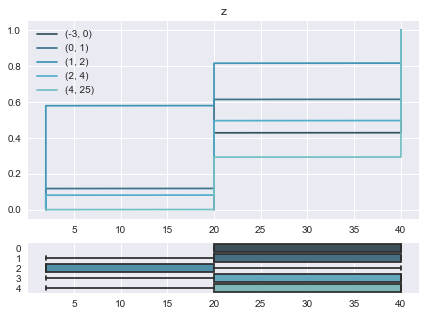

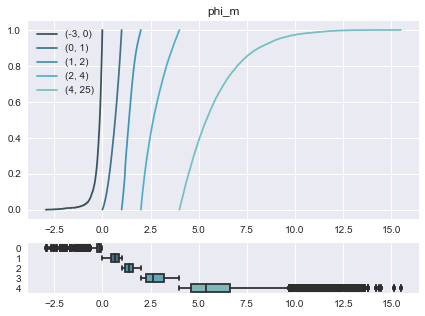

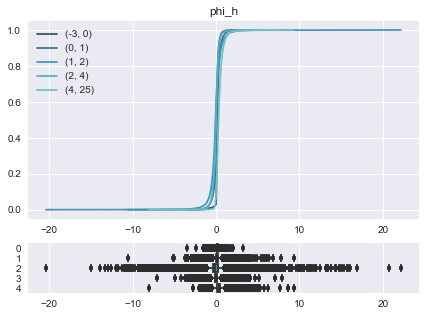

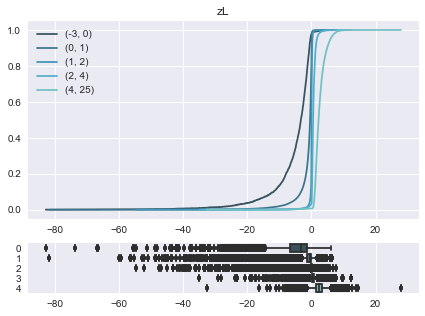

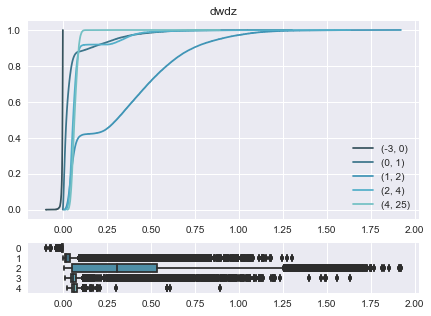

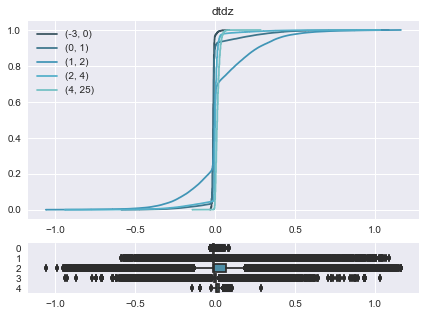

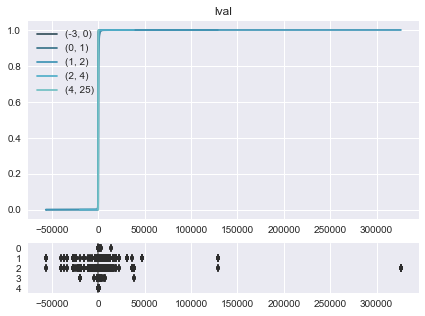

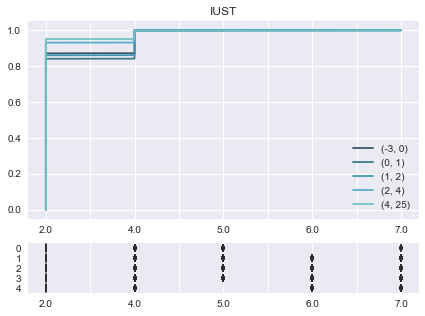

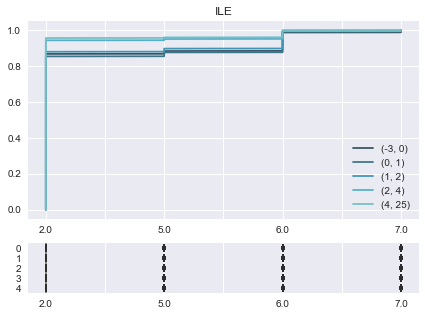

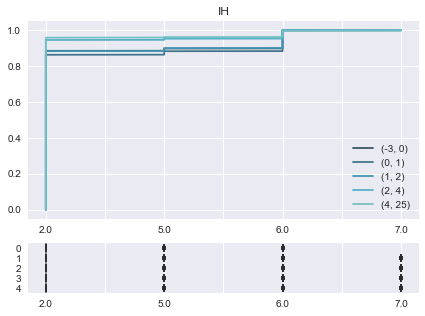

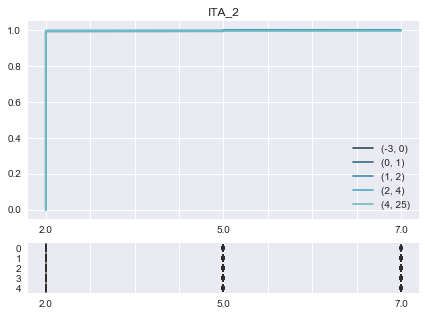

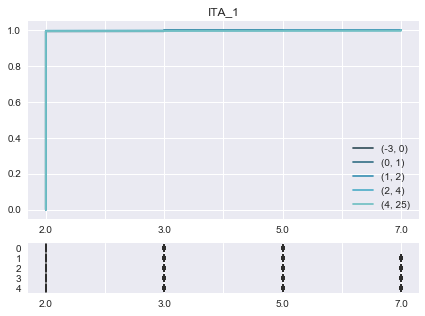

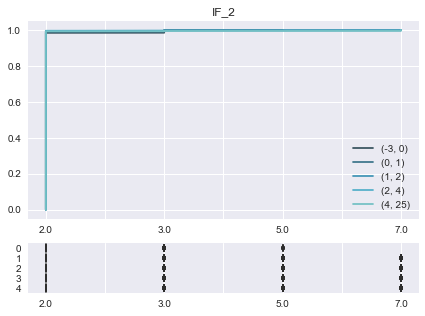

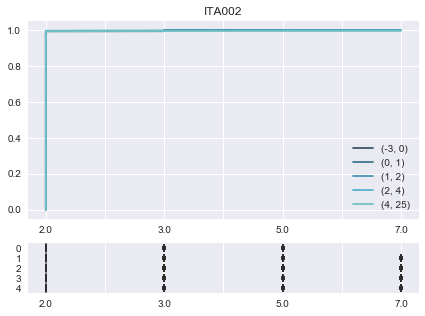

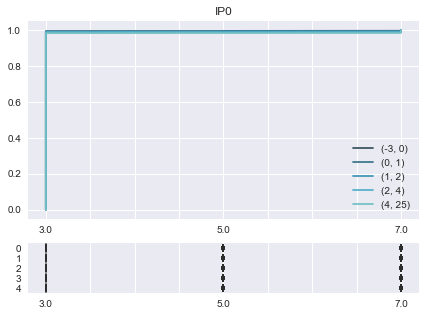

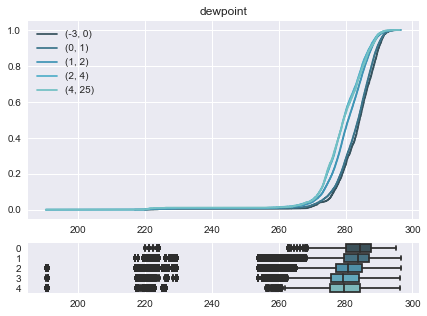

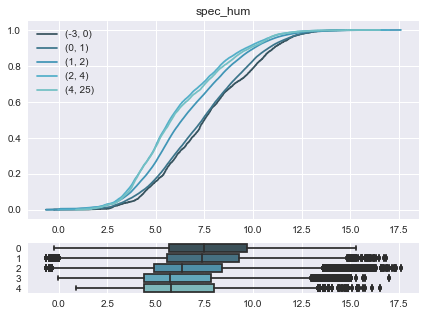

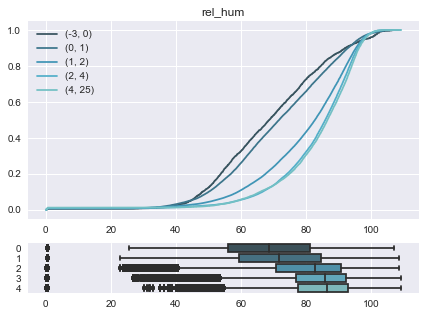

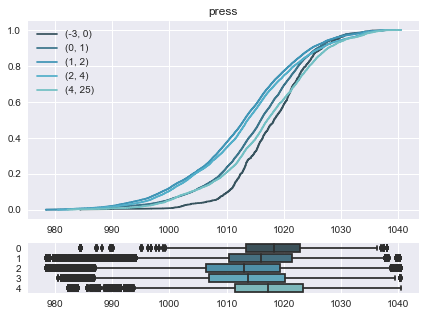

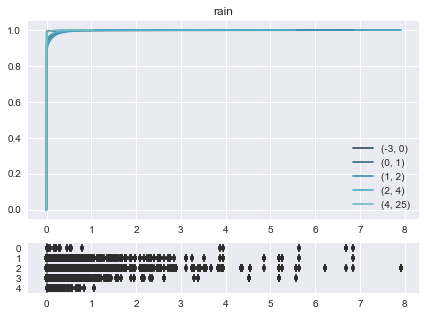

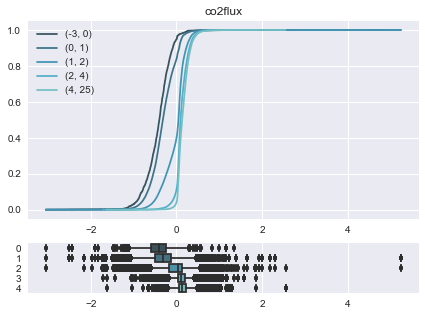

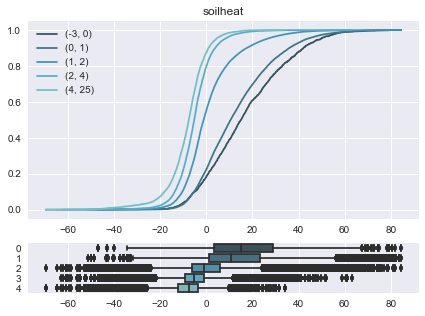

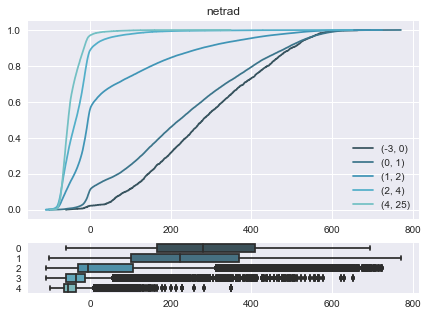

In [31]:
for col in df.columns:
    inspect_col(col, 'phi_m', ints)

seems like the source of the data (I-columns) does not play a big role in differentiating the phi levels

we see larger $\phi_m$s associated with
 - denser air
 - colder surface temperature
 - more wind
 - larger and mostly positive temperature gradient
 - lower heat fluxes

this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

highest $u_*$ in moderately stable conditions, low values in unstable and highly stable conditions; this makes sense, because in unstable conditions most tke comes from eddy fluxes caused by buoyancy, and in very stable conditions we have a calm surface layer with little turbulence. in both cases wind shear does not generate much turbulence

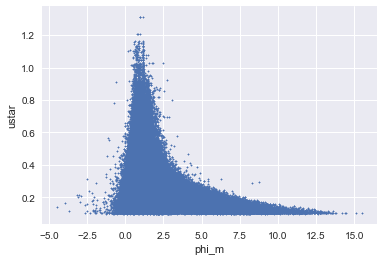

In [32]:
df.plot.scatter('phi_m', 'ustar', s=1)

there seems to be a curious pattern in the time of the month when data with small and large phi values is obtained:

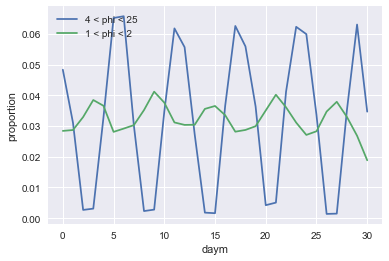

In [33]:
small_mask = (df.phi_m > 4) & (df.phi_m < 25)
large_mask = (df.phi_m > 1) & (df.phi_m < 2)

plt.plot(df[small_mask].groupby(df.daym).size() / len(df[small_mask]), label='4 < phi < 25')
plt.plot(df[large_mask].groupby(df.daym).size() / len(df[large_mask]), label='1 < phi < 2')
plt.xlabel('daym')
plt.ylabel('proportion')
plt.legend()
plt.show()

this pattern happens for other measured variables

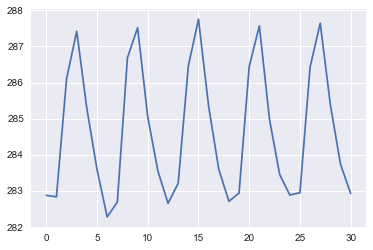

In [34]:
plt.plot(df.groupby(df.daym).temp.mean())

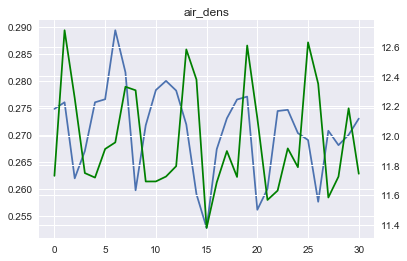

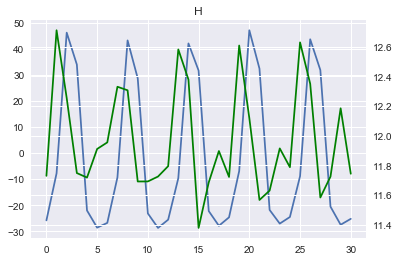

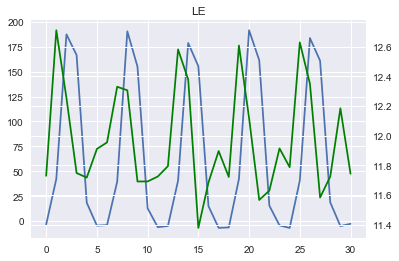

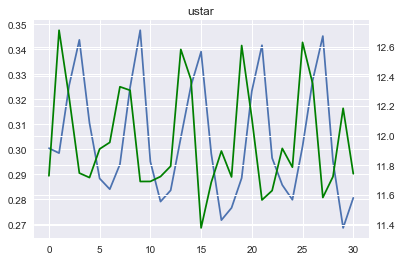

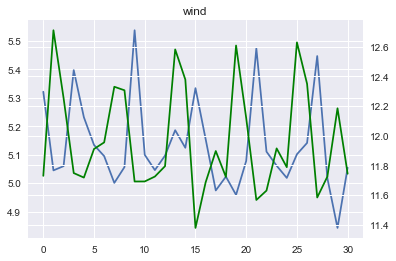

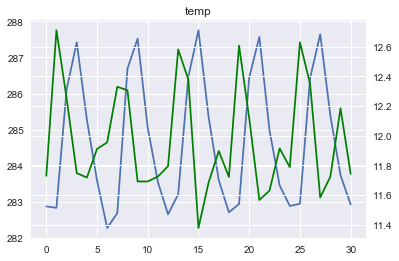

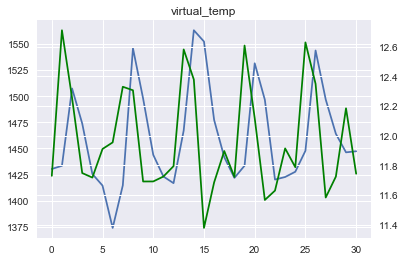

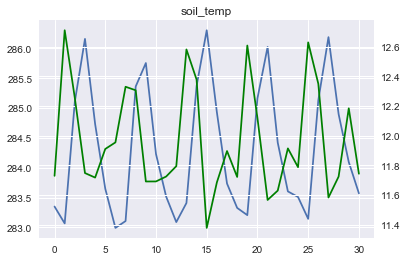

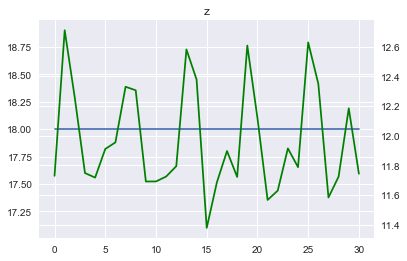

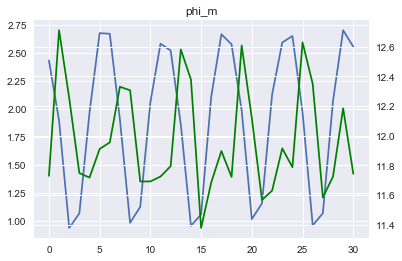

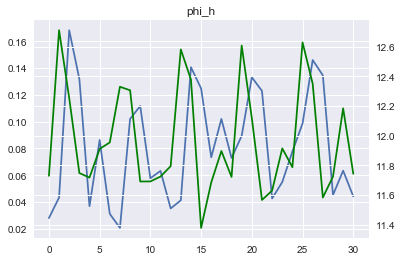

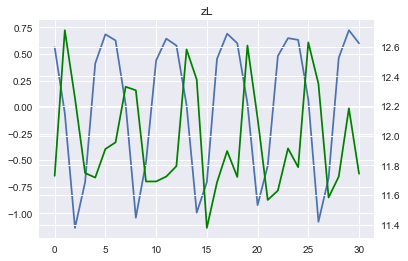

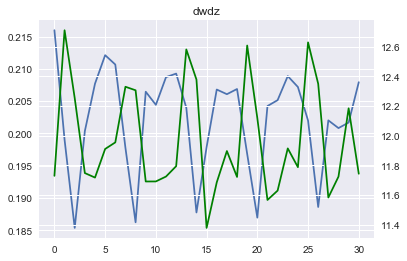

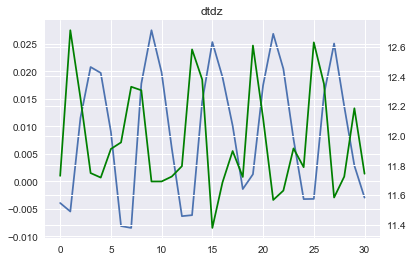

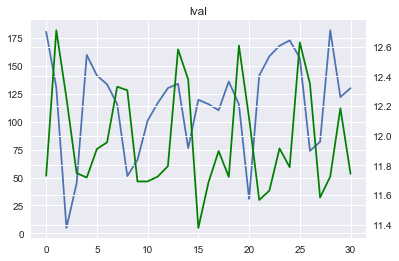

In [35]:
for var in measurement_cols + computed_cols:
    plt.plot(df.groupby(df.daym)[var].mean())
    ax2=plt.gca().twinx()
    ax2.plot(df.groupby(df.daym).hday.mean(), c='g')
    plt.title(var)
    plt.show()

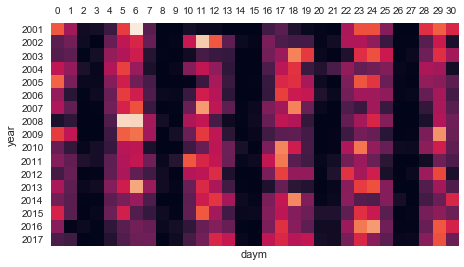

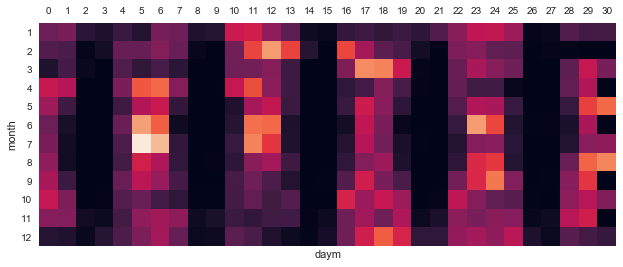

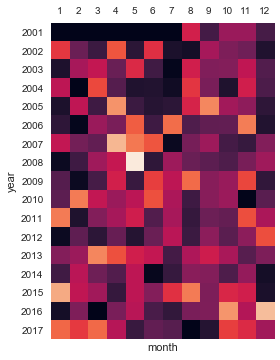

In [36]:
def matcount(row, col, transpose=False, norm=False):
    mat = (df[small_mask]
        .groupby(row)[col].value_counts()
        .rename('count').reset_index()
        .pivot(index=col, columns=row)
        .fillna(0).as_matrix())

    if norm:
        mat = mat / mat.sum(axis=0)
    
    if transpose:
        mat = mat.T
        row, col = col, row

    plt.matshow(mat)
    plt.xticks(range(len(df[row].unique())), sorted(df[row].unique()))
    plt.yticks(range(len(df[col].unique())), sorted(df[col].unique()))
    plt.xlabel(row)
    plt.ylabel(col)
    plt.grid(False)


matcount('year', 'daym', True, True) # normalize by year, transpose to plot horizontally
matcount('month', 'daym', True, True) # normalize by month, transpose to plot horizontally
matcount('month', 'year')

seems like the 6 days seasonality does not depend on the year nor on the month of the year, if we take into account the fact that some months have way more measures than others

what bothers me is that this 6 days cycle repeats more or less regularly for more than 15 years

<Container object of 40 artists>

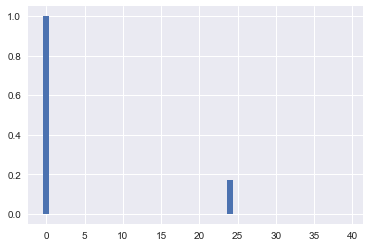

In [37]:
vs = pacf(df.sort_values(['ds', 'tt']).wind)
plt.bar(range(len(vs) - 1), vs[1:])

## inspect z/L (for phi_m)

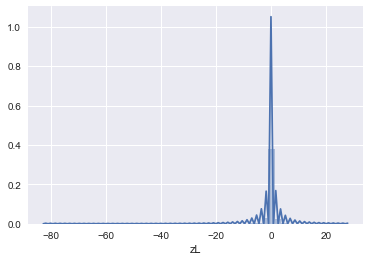

In [38]:
sns.distplot(df.zL)

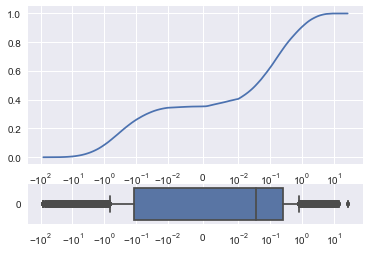

In [39]:
ax1, ax2 = plot_cdf([df.zL], labels=None)
ax1.set_xscale('symlog', linthreshx=1e-2)
ax2.set_xscale('symlog', linthreshx=1e-2)

In [43]:
bins = [
    -90, -1, 0, 1, 30
]

(df.zL.groupby(np.digitize(df.zL, bins))
     .size().rename(lambda b: '[%6.0e, %6.0e)' % (bins[b - 1], bins[b])))

[-9e+01, -1e+00)     171042
[-1e+00,  0e+00)     536622
[ 0e+00,  1e+00)    1104450
[ 1e+00,  3e+01)     189630
Name: zL, dtype: int64

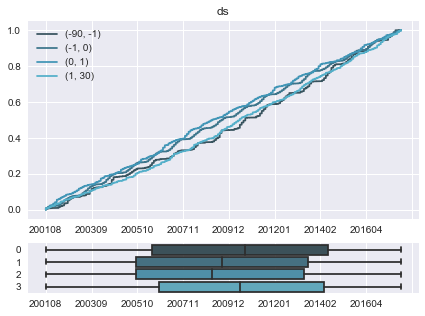

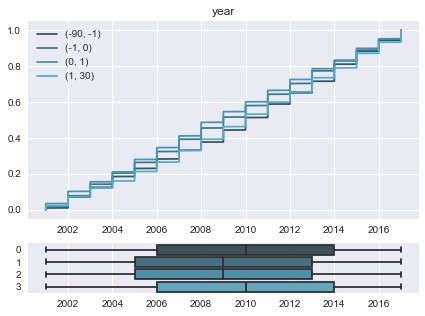

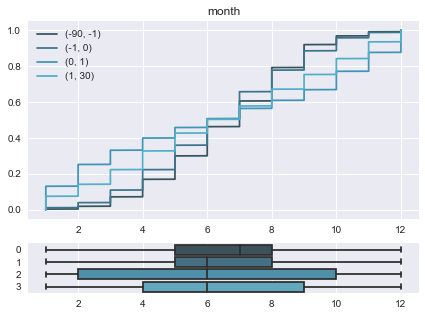

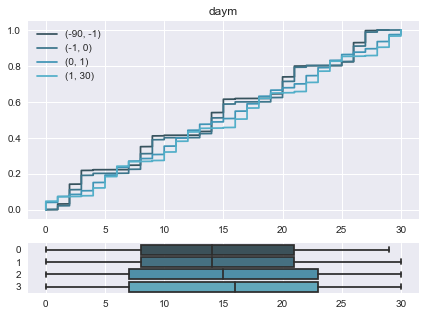

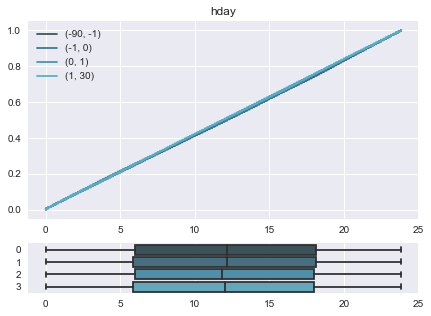

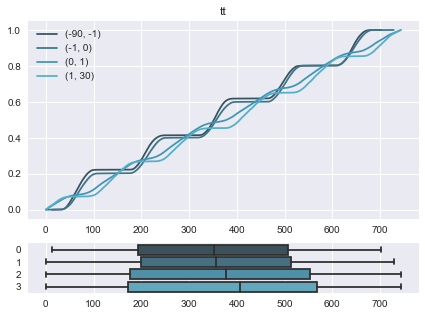

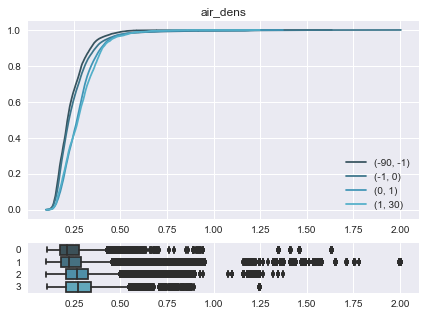

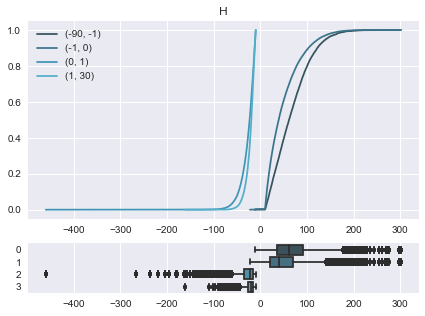

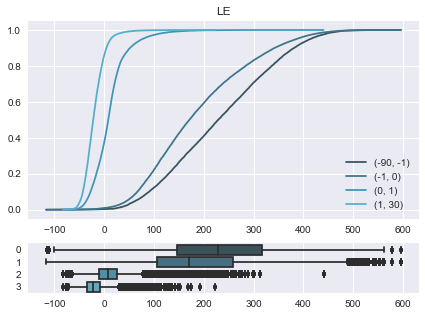

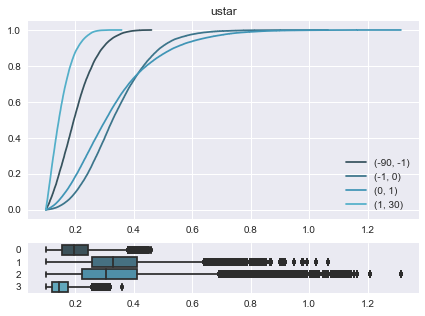

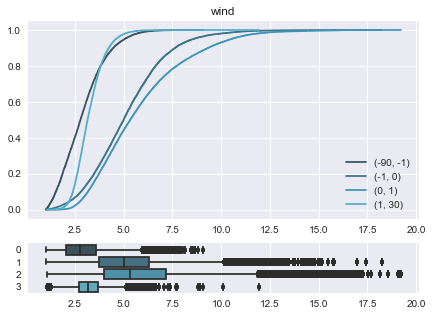

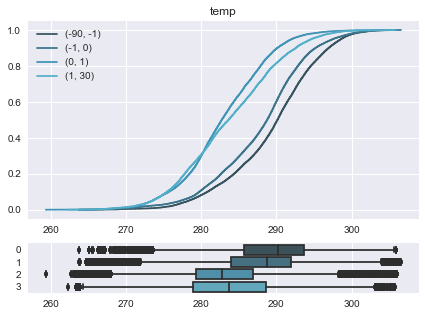

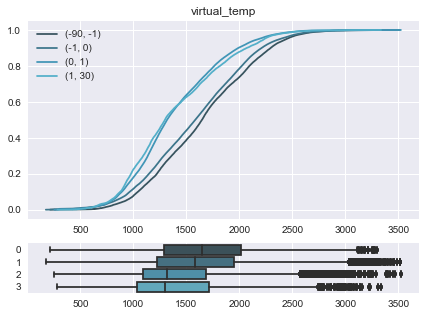

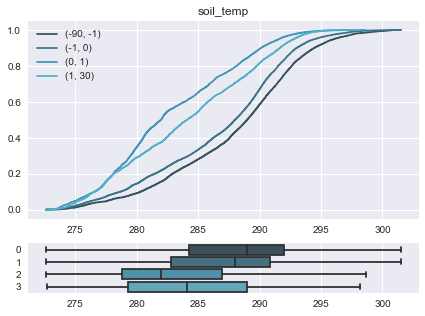

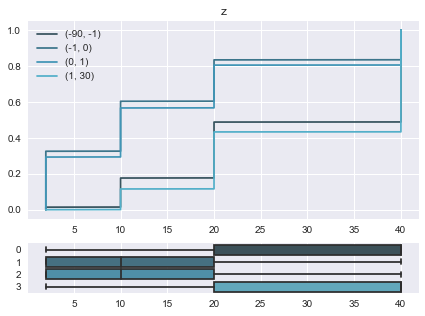

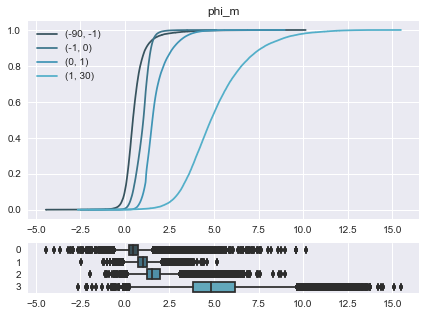

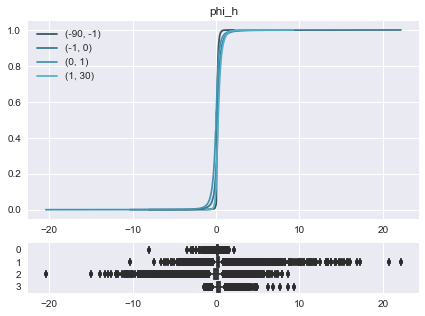

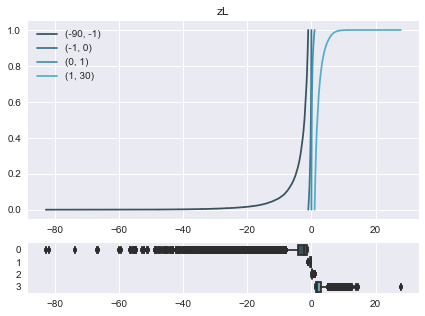

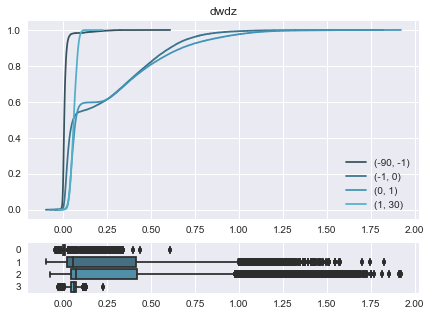

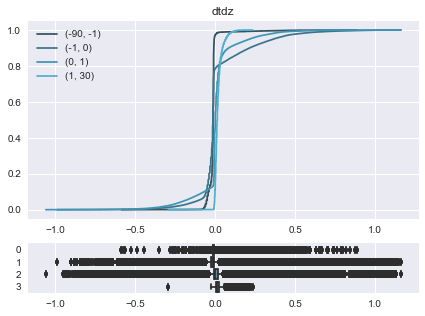

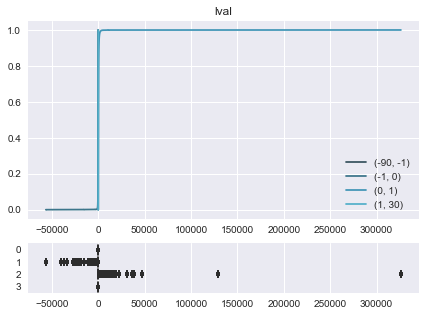

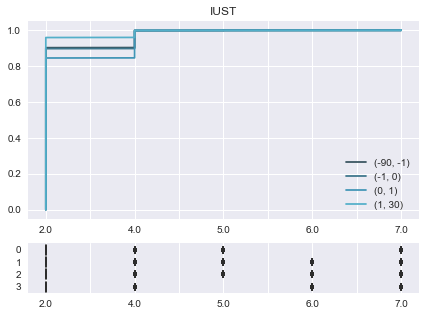

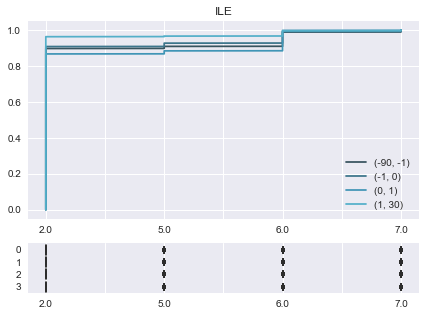

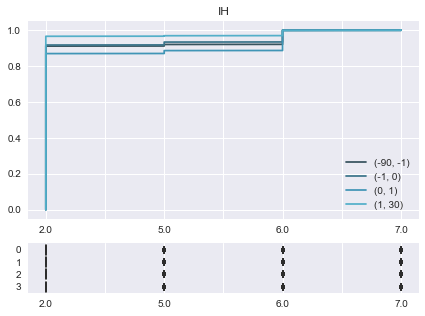

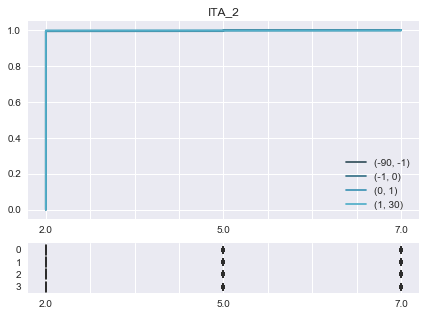

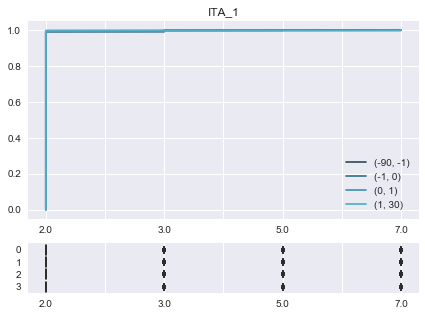

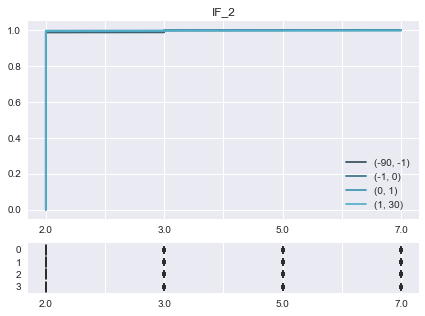

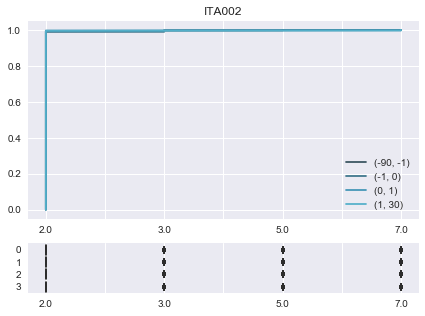

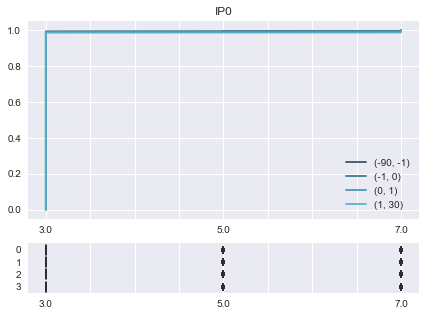

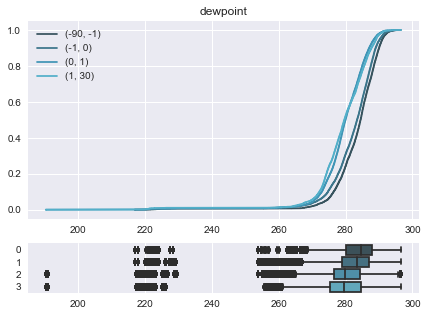

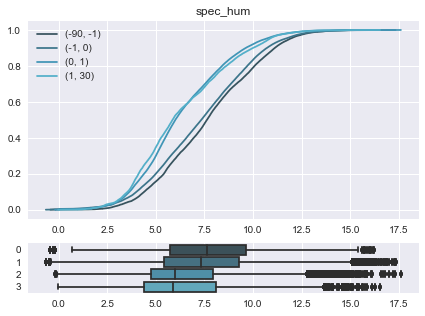

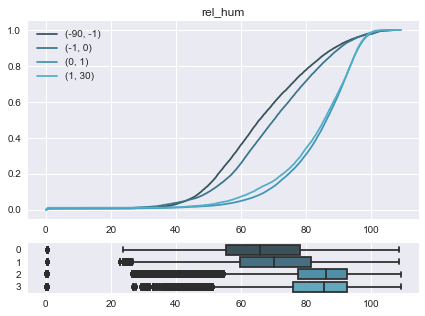

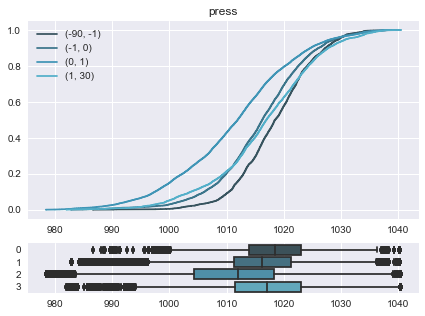

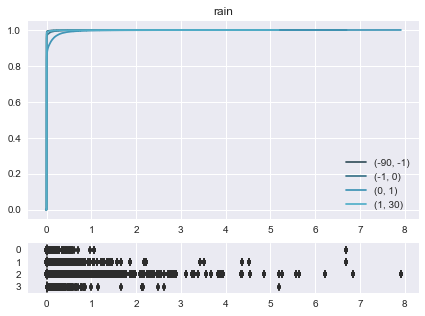

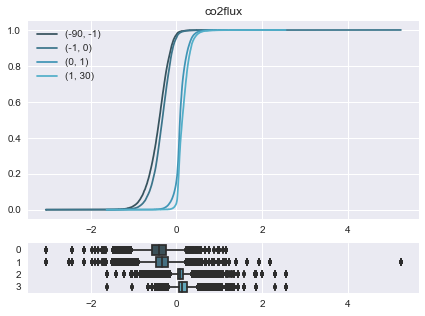

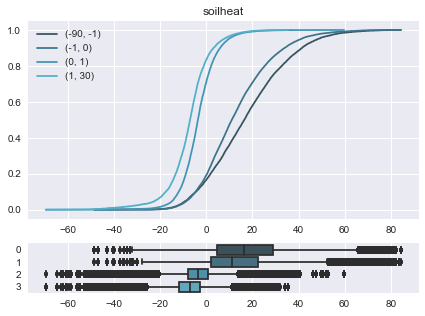

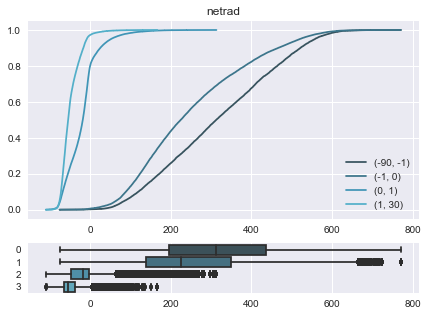

In [44]:
for col in df.columns:
    inspect_col(col, 'zL', bins)

In [46]:
(df.groupby(np.digitize(df.zL, bins))
     [['ustar', 'wind', 'LE', 'temp', 'phi_m']].mean()
     .rename(lambda b: '[%6.0f, %6.0f)' % (bins[b - 1], bins[b])))

ustar      wind          LE        temp     phi_m
[   -90,     -1)  0.204306  2.904412  232.771705  289.477076  0.558625
[    -1,      0)  0.341185  5.147293  188.422113  287.944822  0.992667
[     0,      1)  0.333401  5.825166   11.320854  282.967500  1.719495
[     1,     30)  0.152503  3.241724  -20.048698  283.796584  5.138975